In [1]:
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
import time
import pandas as pd
from sklearn import metrics

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

In [2]:
folder_path = f"/kaggle/working/run/"
os.makedirs(folder_path, exist_ok=True)

# Tentukan path
checkpoint_path = os.path.join(folder_path, "best_model.h5")
convert_path = os.path.join(folder_path, "converted_model.tflite")
loss_image_path = os.path.join(folder_path, 'validation loss.png')
acc_image_path = os.path.join(folder_path, 'validation accuracy.png')
confusion_image_path = os.path.join(folder_path, 'confusion matrix.png')
log_path = os.path.join(folder_path, 'training.log')

In [3]:
# Path dataset
dataset_dir = "/kaggle/input/sibi-dataset/dataset"
train_dir = os.path.join(dataset_dir, "Train")
valid_dir = os.path.join(dataset_dir, "Valid")
test_dir = os.path.join(dataset_dir, "Test")

# Hyperparameter
num_classes = 27
learning_rate = 0.001
epochs = 100
batch_size = 16

# Dimensi input gambar
image_size = (224, 224)

# Pembuatan objek ImageDataGenerator untuk augmentasi data
train_data_gen = ImageDataGenerator(
    rescale=1./255, 
    shear_range=0.2, 
    zoom_range=0.2, 
    horizontal_flip=True,
)

valid_data_gen = ImageDataGenerator(rescale=1./255)

test_data_gen = ImageDataGenerator(rescale=1./255)

# Pembuatan generator untuk dataset pelatihan dan validasi
train_generator = train_data_gen.flow_from_directory(
    train_dir, 
    target_size=image_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True,
)

valid_generator = valid_data_gen.flow_from_directory(
    valid_dir, 
    target_size=image_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True,
)

test_generator = test_data_gen.flow_from_directory(
    test_dir, 
    target_size=image_size, 
    batch_size=batch_size, 
    class_mode='categorical',
    shuffle=True,
)

Found 4590 images belonging to 27 classes.
Found 1350 images belonging to 27 classes.
Found 243 images belonging to 27 classes.


In [4]:
# Membuat model MobileNet
base_model = MobileNetV2(
    weights='imagenet', 
    include_top=False, 
    input_shape=(image_size[0], image_size[1], 3),
)

for layer in base_model.layers :
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

9406464/9406464 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                               

In [5]:
model.compile(optimizer=Adam(learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

# callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint(checkpoint_path, monitor='val_loss', save_best_only=True)
csv_logger = CSVLogger(log_path, separator=',', append=False)

# Hitung waktu training
start_time = time.time()

# Latih model dengan menggunakan model checkpoint
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=valid_generator,
    callbacks=[model_checkpoint, csv_logger, early_stopping],
)

# Hitung waktu training
end_time = time.time()

Epoch 1/100
287/287 [==============================] - 82s 255ms/step - loss: 1.6857 - accuracy: 0.6804 - val_loss: 0.6917 - val_accuracy: 0.8037
Epoch 2/100
287/287 [==============================] - 58s 201ms/step - loss: 0.1945 - accuracy: 0.9405 - val_loss: 0.3225 - val_accuracy: 0.8985
Epoch 3/100
287/287 [==============================] - 57s 200ms/step - loss: 0.0854 - accuracy: 0.9712 - val_loss: 0.8051 - val_accuracy: 0.8615
Epoch 4/100
287/287 [==============================] - 57s 198ms/step - loss: 0.1460 - accuracy: 0.9582 - val_loss: 0.2749 - val_accuracy: 0.9230
Epoch 5/100
287/287 [==============================] - 59s 204ms/step - loss: 0.0914 - accuracy: 0.9756 - val_loss: 0.2891 - val_accuracy: 0.9444
Epoch 6/100
287/287 [==============================] - 56s 197ms/step - loss: 0.1008 - accuracy: 0.9754 - val_loss: 0.3076 - val_accuracy: 0.9274
Epoch 7/100
287/287 [==============================] - 56s 196ms/step - loss: 0.0608 - accuracy: 0.9813 - val_loss: 0.6771 -

In [6]:
print("Training Time", end_time - start_time)

Training Time 1936.267718553543


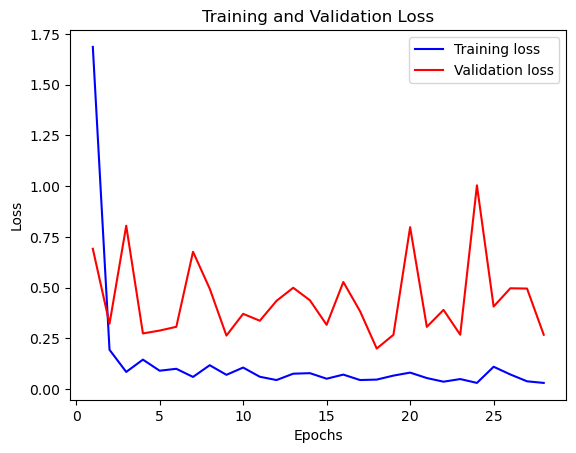

In [7]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss)+1)
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(loss_image_path)
plt.show()

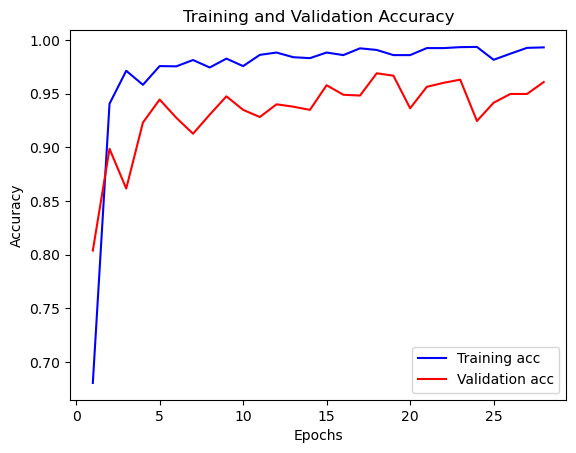

In [8]:
acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [12]:
# Evaluasi model pada dataset uji
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

16/16 [==============================] - 1s 33ms/step - loss: 0.6863 - accuracy: 0.9465
Test Loss: 0.6863, Test Accuracy: 0.9465


In [18]:
# Prediksi kelas menggunakan model pada dataset uji
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred_labels = np.argmax(y_pred_probs, axis=1)

# Classification report
target_names = [f'class {i}' for i in range(num_classes)]
classification_rep = classification_report(y_true, y_pred_labels, target_names=target_names)
print(classification_rep)

16/16 [==============================] - 1s 32ms/step
              precision    recall  f1-score   support

     class 0       0.00      0.00      0.00         9
     class 1       0.00      0.00      0.00         9
     class 2       0.00      0.00      0.00         9
     class 3       0.00      0.00      0.00         9
     class 4       0.15      0.22      0.18         9
     class 5       0.00      0.00      0.00         9
     class 6       0.00      0.00      0.00         9
     class 7       0.00      0.00      0.00         9
     class 8       0.09      0.11      0.10         9
     class 9       0.00      0.00      0.00         9
    class 10       0.00      0.00      0.00         9
    class 11       0.00      0.00      0.00         9
    class 12       0.00      0.00      0.00         9
    class 13       0.00      0.00      0.00         9
    class 14       0.00      0.00      0.00         9
    class 15       0.11      0.11      0.11         9
    class 16       0.00    

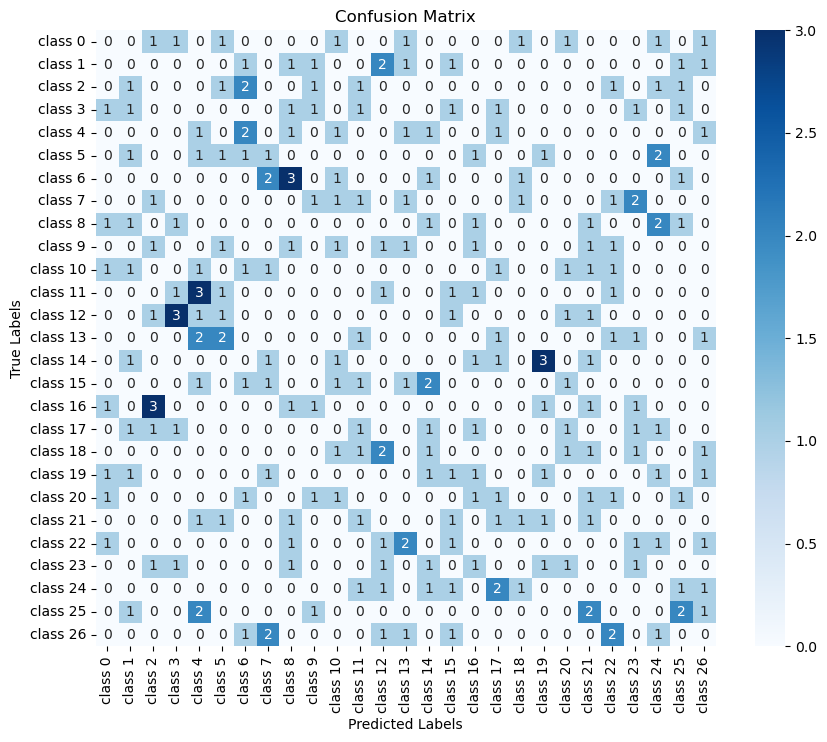

In [15]:
# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_labels)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.savefig(confusion_image_path)
plt.show()

In [16]:
import tensorflow as tf

# Load model Keras (.h5)
model = tf.keras.models.load_model(checkpoint_path)

# Konversi model menjadi TFLite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TFLite sebagai file .tflite
with open(convert_path, 'wb') as f:
    f.write(tflite_model)

1/1 [==============================] - 0s 24ms/step


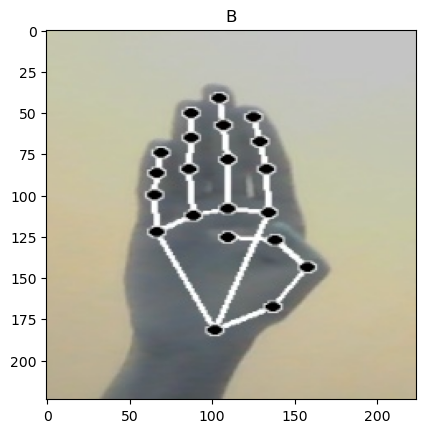

In [23]:
import cv2
file_dir = "/kaggle/input/sibi-dataset/dataset/Test/B/image_B_(1685193326.274505).jpg"
CATEGORIES = [chr(i + 65) for i in range(26)] + ['spasi']

read_img = cv2.imread(file_dir, cv2.COLOR_BGR2RGB)
img_rescale = (read_img * 1.0) / 255.0
img_resize = cv2.resize(img_rescale, (224, 224))
img_resize_expand = img_resize.reshape(1, *img_resize.shape)
my_prediction = model.predict(img_resize_expand)
my_label = CATEGORIES[np.argmax(my_prediction)]
plt.imshow(read_img)
plt.title(my_label)
plt.show()